In [0]:
# !wget https://www.dropbox.com/s/wmw93urz7e4mqo5/control_beats_6.npy
# beats = np.load('control_beats_6.npy')

In [1]:
import os
import time
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# from torchdiffeq.torchdiffeq import odeint

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from torchdiffeq import odeint

In [2]:
batch_time = 10
batch_size = 20
data_size = 200

viz = True

In [3]:
def get_batch():
    s = torch.from_numpy(np.random.choice(np.arange(data_size - batch_time, dtype=np.int64), batch_size, replace=False))
    batch_y0 = true_y[s]  # (M, D)
    batch_t = t[:batch_time]  # (T)
    batch_y = torch.stack([true_y[s + i] for i in range(batch_time)], dim=0)  # (T, M, D)
    return batch_y0, batch_t, batch_y


def makedirs(dirname):
    if not os.path.exists(dirname):
        os.makedirs(dirname)

In [4]:
DATA_TYPE = 'NNET_MORE'

In [5]:
if viz:
    makedirs(DATA_TYPE)
    import matplotlib.pyplot as plt

def visualize(true_y, pred_y, odefunc, itr):
  
    if viz:
      
        plt.figure()
        plt.plot(t.numpy(), true_y.numpy()[:, 0, 0], t.numpy(), true_y.numpy()[:, 0, 1], 'g-')
        plt.plot(t.numpy(), pred_y.numpy()[:, 0, 0], '--', t.numpy(), pred_y.numpy()[:, 0, 1], 'b--')
        plt.savefig(DATA_TYPE + '/ts' + str(itr) + '.png')
        plt.show()
        
        plt.figure()
        plt.plot(true_y.numpy()[:, 0, 0], true_y.numpy()[:, 0, 1], 'g-')
        plt.plot(pred_y.numpy()[:, 0, 0], pred_y.numpy()[:, 0, 1], 'b--')
        plt.savefig(DATA_TYPE + '/phase' + str(itr) + '.png')
        plt.show()

In [6]:
class RunningAverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self, momentum=0.99):
        self.momentum = momentum
        self.reset()

    def reset(self):
        self.val = None
        self.avg = 0

    def update(self, val):
        if self.val is None:
            self.avg = val
        else:
            self.avg = self.avg * self.momentum + val * (1 - self.momentum)
        self.val = val

In [7]:
class ODEFunc(nn.Module):

    def __init__(self):
        super(ODEFunc, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(2, 50),
            nn.Tanh(),
            nn.Linear(50, 2),
        )

        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.1)
                nn.init.constant_(m.bias, val=0)

    def forward(self, t, y):
        return self.net(y)


In [8]:
true_y0 = torch.tensor([[1., 1.]])
t = torch.linspace(-1., 1., data_size)

# true_A = torch.tensor([[-0.1, 2.0], [-2.0, -0.1]])
# true_A = torch.randn(2, 2)/2.

# a, b, c, d = 1.5, 1.0, 3.0, 1.0
# true_A = torch.tensor([[0., -b*c/d], [d*a/b, 0.]])

# true_A2 = torch.tensor([[-0.1, -0.5], [0.5, -0.1]])
# true_B2 = torch.tensor([[0.2, 1.], [-1, 0.2]])

class Lambda(nn.Module):

    def forward(self, t, y):
        return torch.mm(y, true_A)
   
      
class Lambda2(nn.Module):
    
    def __init__(self, A, B):
        super(Lambda2, self).__init__()
        self.A = nn.Linear(2, 2, bias=False)
        self.A.weight = nn.Parameter(A)
        self.B = nn.Linear(2, 2, bias=False)
        self.B.weight = nn.Parameter(B)
    
    def forward(self, t, y):
        xTx0 = torch.sum(y * true_y0, dim=1)
        dxdt = torch.sigmoid(xTx0) * self.A(y - true_y0) + torch.sigmoid(-xTx0) * self.B(y + true_y0)
        return dxdt
      
# with torch.no_grad():
#     true_y = odeint(Lambda2(true_A2, true_B2), true_y0, t, method='dopri5')
    
# with torch.no_grad():
#     true_y = odeint(Lambda(), true_y0, t, method='dopri5')

In [9]:
true_y0 = torch.tensor([[1., 1.]])
t = torch.linspace(-15., 15., data_size)
class Lambda3(nn.Module):
    def __init__(self):
        super(Lambda3, self).__init__()
        self.fc1 = nn.Linear(2, 25, bias = False)
        self.fc2 = nn.Linear(25, 50, bias = False)
        self.fc3 = nn.Linear(50, 10, bias = False)
        self.fc4 = nn.Linear(10, 2, bias = False)
        self.relu = nn.ELU(inplace=True)
        
    def forward(self, t, y):
        x = self.relu(self.fc1(y * t))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        return x
     
with torch.no_grad():
    true_y = odeint(Lambda3(), true_y0, t, method='dopri5')

In [10]:
class ODEFunc(nn.Module):
    def __init__(self):
        super(ODEFunc, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 150),
            nn.Tanh(),
            nn.Linear(150, 50),
            nn.Tanh(),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Linear(50, 2),)
        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.1)
                nn.init.constant_(m.bias, val=0)

    def forward(self, t, y):
        return self.net(y)


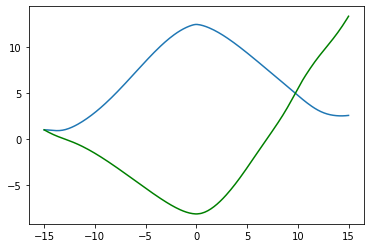

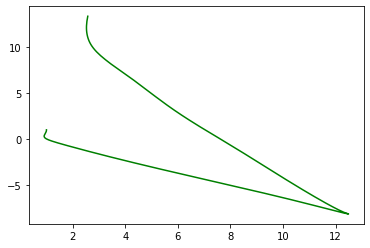

In [11]:
plt.figure()
plt.plot(t.numpy(), true_y.numpy()[:, 0, 0], t.numpy(), true_y.numpy()[:, 0, 1], 'g-')
plt.show()

plt.figure()
plt.plot(true_y.numpy()[:, 0, 0], true_y.numpy()[:, 0, 1], 'g-')
plt.show()

In [0]:
  ii = 0
  niters = 5000

  func = ODEFunc()
  optimizer = optim.RMSprop(func.parameters(), lr=1e-3)
  end = time.time()

  time_meter = RunningAverageMeter(0.97)
  loss_meter = RunningAverageMeter(0.97)

  for itr in range(1, niters + 1):
      optimizer.zero_grad()
      batch_y0, batch_t, batch_y = get_batch()
      pred_y = odeint(func, batch_y0, batch_t)
      loss = torch.mean(torch.abs(pred_y - batch_y))
      loss.backward()
      optimizer.step()

      time_meter.update(time.time() - end)
      loss_meter.update(loss.item())

      if itr % 50 == 0:
          with torch.no_grad():
              pred_y = odeint(func, true_y0, t)
              loss = torch.mean(torch.abs(pred_y - true_y))
              print('Iter {:04d} | Total Loss {:.6f}'.format(itr, loss.item()))
              visualize(true_y, pred_y, func, ii)
              ii += 1

      end = time.time()

In [12]:
# !zip -r /content/VOLTERLOTKA.zip /content/VOLTERLOTKA

In [0]:
# from google.colab import files

In [0]:
# files.download("/content/AB.zip")

In [0]:
# import imageio
# import glob

In [0]:
# kargs = { 'duration': 0.5 }
# PATH = sorted(glob.glob('/content/VOLTERLOTKA/*.png'))

# images = []
# for filename in PATH:
#     if 'ts' in filename:
#       images.append(imageio.imread(filename))
# imageio.mimsave('/content/VOLTERLOTKA/movie_ts.gif', images, **kargs)

# images = []
# for filename in PATH:
#     if 'phase' in filename:
#       images.append(imageio.imread(filename))
# imageio.mimsave('/content/VOLTERLOTKA/movie_phase.gif', images, **kargs)